## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this task, implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
  

In [ ]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

In [ ]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.jpg  
 extracting: val2014/COCO_val2014_000000157465.jpg  
 extracting: val2014/COCO_val2014_000000218224.jpg  
 extracting: val2014/COCO_val2014_000000030548.j

In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
from nltk.translate.bleu_score import SmoothingFunction
import faiss
import numpy as np

In [ ]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.89s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [ ]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [ ]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [ ]:
cap_path = '/content/drive/MyDrive/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [ ]:
img_path = '/content/drive/MyDrive/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [ ]:
def accuracy_v2(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split()
    smooth = SmoothingFunction()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre),smoothing_function=smooth.method1)
        accuracy += score
    return accuracy/len(predict)

In [ ]:
# Train test split
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

img_train, img_test, captions_train, captions_test, indices_train, indices_test = train_test_split(image_embeddings, caption_embeddings, range(len(image_embeddings)), test_size=0.2)


In [ ]:
# function to compute knn
def compute_knn(k_neighbors):
    return np.transpose(np.array(list(faiss.knn(img_test, img_train, k_neighbors))), [1, 2, 0])

# function to get query vector
def get_query_vector(neighbors, k):
    query_vector = np.zeros((512))

    for d, i in neighbors:
        query_vector += ((1 - d) / (k * 5)) * np.sum(captions_train[int(i)], axis=0)

    return query_vector

# function to get closest caption
def find_closest_caption(train_d, index_lst):
    best_score = 1
    query_caption = None

    for i in index_lst:
        i = int(i)
        dot_products = np.dot(captions_train[i], train_d)
        norms = np.linalg.norm(captions_train[i], axis=1)
        calculated_scores = dot_products / (norms * np.linalg.norm(train_d))

        min_score_index = np.argmin(np.abs(calculated_scores))

        if abs(calculated_scores[min_score_index]) < best_score:
            best_score = abs(calculated_scores[min_score_index])
            query_caption = [indices_train[i], min_score_index]

    return query_caption


In [ ]:
k_values = [3,5,10,25]
bleu_scores = []
for k in k_values:
    # Compute k-NN using Faiss
    k_neighbors_result = compute_knn(k)

    # List to store query vectors
    query_vectors = []

    # Calculate query vectors for each test image
    for neighbor_set in k_neighbors_result:
        train_distance_vector = get_query_vector(neighbor_set, k)
        closest_caption = find_closest_caption(train_distance_vector, neighbor_set.T[1])
        query_vectors.append(closest_caption)

    # Lists to store predicted and actual captions
    predicted_captions = []
    actual_captions = []

    # Populate lists for accuracy calculation
    for i in range(len(query_vectors)):
        img, target_caption = coco_dset[indices_test[i]]
        actual_captions.append(target_caption)
        predicted_captions.append(captions[query_vectors[i][0]][query_vectors[i][1]])

    # Calculate and print the accuracy for each value of k
    accuracy_score = accuracy_v2(predicted_captions, actual_captions)
    bleu_scores.append(accuracy_score)
    print(f'BLEU score accuracy for k={k}: {accuracy_score}')


BLEU score accuracy for k=3: 0.07342985749169946
BLEU score accuracy for k=5: 0.06789525653251445
BLEU score accuracy for k=10: 0.06174127232487924


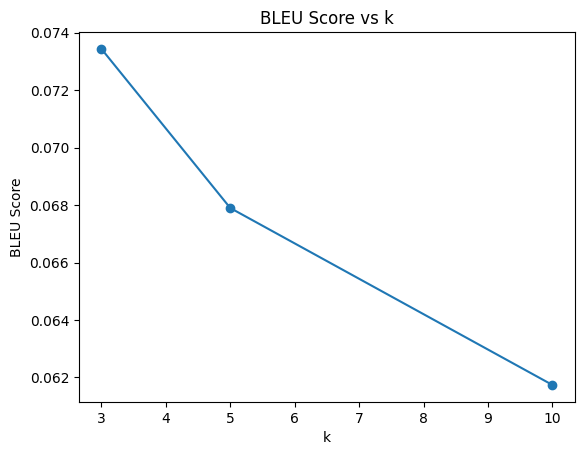

In [ ]:
# Plot BLEU score vs k
plt.plot(k_values, bleu_scores, marker='o')
plt.xlabel('k')
plt.ylabel('BLEU Score')
plt.title('BLEU Score vs k')
plt.show()

Observations

*   Bleu score is decreasing with increase in k.




In [ ]:
# visualize image with truth captions and predicted caption

def visualize_image(index):
    # Load the image
    img, target = coco_dset[indices_test[index]]
    img_array = np.transpose(img, (1, 2, 0))

    # Display the image
    plt.imshow(img_array)
    print(target)
    print(captions[query_vectors[index][0]][query_vectors[index][1]])
    plt.show()

['A group of stuffed animals sitting on top of a wall.', 'This is a picture of four stuffed animals.', 'Three teddy bears and a stuffed cat on a stone wall.', 'Four stuffed animals, a leopard and three teddy bears, in a row sitting on a stone ledge with grass and trees behind.', 'A bunch of teddy bears sitting on a stone wall.']
Two grey teddy bears wearing bright knit hats and sweaters


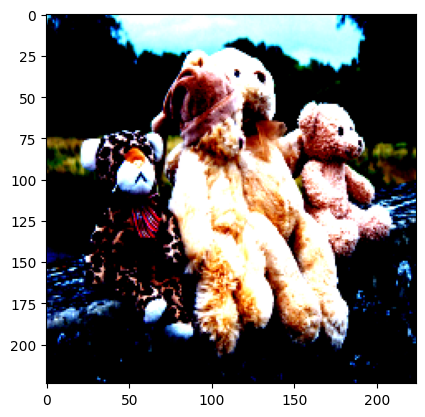

['Two tall giraffes standing next to each other by trees.', 'Two giraffes nudging over a pole in a forested area', 'Two giraffes eat from a tall food post in their enclosure.', 'Giraffes standing in a wooded area, touching heads.', 'Two giraffe standing in a field next to trees.']
A giraffe is eating out of a basket.


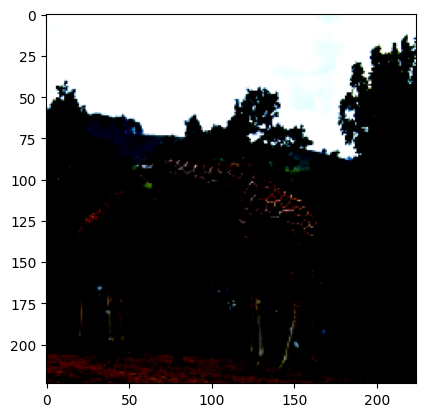

['A pair of umbrellas sitting on a beach near the ocean.', 'A sandy beach with two white umbrellas on it.', 'two beach umbrellas in the sand at the beach', 'Two umbrellas are on a sandy ocean beach.', 'The view from underneath two beach umbrellas looking out onto the beach and towards the water.']
Three surfers walking along the beach after a swim.


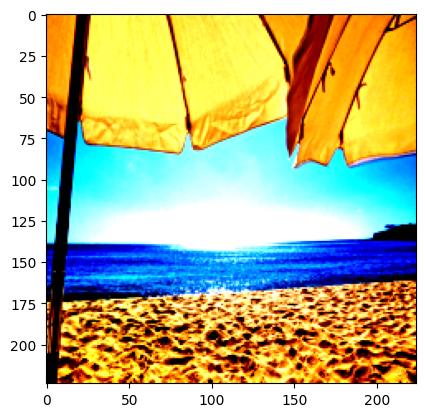

['skateboarder who is about to land from a jump of some type', 'A man is flipping a skateboard while doing tricks.', 'A boy blurs down a hill on his skateboard in front of a graffiti wall.', 'A boy doing a trick on a skateboard onto a rail.', 'MAN  ON A SKATEBOARD IN THE AIR, WITH A BLURRY BACKGROUND']
A female skateboarding barefoot with a purple effect applied to background. 


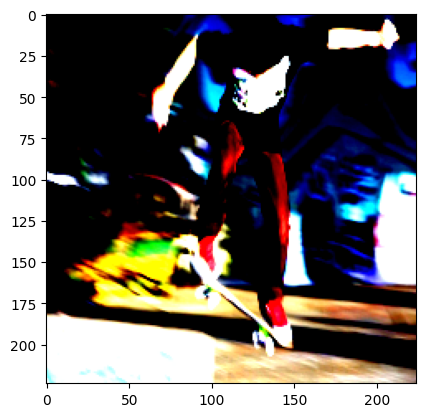

['Two giraffe standing next to a chain link fence.', 'Two giraffes in a green fenced in area', 'Two giraffes in a zoo or sanctuary pen.', 'A giraffe standing next to a fence in its enclosure', 'A giraffe is standing behind a fence at a zoo']
A group of giraffe standing next to a wooden fence.


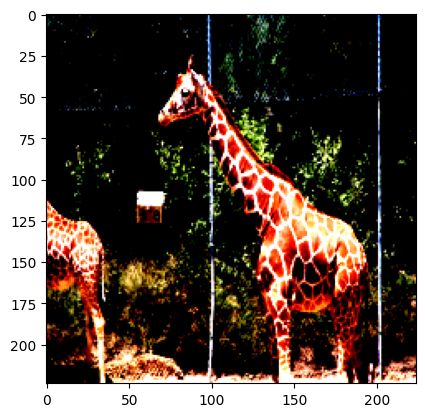

In [ ]:
for i in range(5):
  ind = np.random.choice(range(len(img_test)))
  visualize_image(ind)
